In [1]:
import pandas as pd
import numpy as np
import numpy.typing as npt
from datetime import datetime

import yfinance as yf
from utility.types import AllocationMethodsEnum

from data.benchmark import Benchmark
from data.universe import Universe
from backtest.backtest import Backtester

In [2]:
bench = Benchmark()
bench.get_benchmark_history()

date
2000-01-03     498.122
2000-01-04     479.035
2000-01-05     479.457
2000-01-06     475.892
2000-01-07     489.011
                ...   
2024-04-15    1975.708
2024-04-16    1967.475
2024-04-17    1947.947
2024-04-18    1942.958
2024-04-19    1947.656
Freq: B, Name: RTY Index, Length: 6340, dtype: float64

In [3]:
univ = Universe()
df = univ.get_universe_history()

[*********************100%%**********************]  10 of 10 completed


In [4]:
from typing import Dict, List  # MMM->APPL->AMZN | MSFT->AFL | BSX -> IP

from utility.types import SpinOff


spin_off_announcement: Dict[datetime, List[SpinOff]] = {
    datetime(2015, 12, 10): [
        SpinOff(
            parent_company="AMZN",
            subsidiary_company="MMM",
            spin_off_ex_date=datetime(2015, 12, 15),
        )
    ],
    datetime(2005, 10, 14): [
        SpinOff(
            parent_company="MSFT",
            subsidiary_company="AFL",
            spin_off_ex_date=datetime(2005, 10, 17),
        ),
        SpinOff(
            parent_company="AAPL",
            subsidiary_company="AMZN",
            spin_off_ex_date=datetime(2005, 10, 18),
        ),
    ],
    datetime(2008, 2, 15): [
        SpinOff(
            parent_company="BSX",
            subsidiary_company="IP",
            spin_off_ex_date=datetime(2008, 2, 18),
        ),
        SpinOff(
            parent_company="BSX",
            subsidiary_company="MC.PA",
            spin_off_ex_date=datetime(2008, 2, 18),
        ),
    ],
}

spin_off_announcement

{datetime.datetime(2015, 12, 10, 0, 0): [SpinOff(parent_company='AMZN', subsidiary_company='MMM', spin_off_ex_date=datetime.datetime(2015, 12, 15, 0, 0))],
 datetime.datetime(2005, 10, 14, 0, 0): [SpinOff(parent_company='MSFT', subsidiary_company='AFL', spin_off_ex_date=datetime.datetime(2005, 10, 17, 0, 0)),
  SpinOff(parent_company='AAPL', subsidiary_company='AMZN', spin_off_ex_date=datetime.datetime(2005, 10, 18, 0, 0))],
 datetime.datetime(2008, 2, 15, 0, 0): [SpinOff(parent_company='BSX', subsidiary_company='IP', spin_off_ex_date=datetime.datetime(2008, 2, 18, 0, 0)),
  SpinOff(parent_company='BSX', subsidiary_company='MC.PA', spin_off_ex_date=datetime.datetime(2008, 2, 18, 0, 0))]}

# Analyze parent behavior around spin off


In [5]:
from backtest.analysis import get_spin_off_parent_behavior

DAYS_BEFORE = 50
DAYS_AFTER = 50

behaviours = []

for spinoffs in spin_off_announcement.values():
    for spinoff in spinoffs:
        behaviours.append(
            get_spin_off_parent_behavior(
                univ.get_universe_returns(), spinoff, DAYS_BEFORE, DAYS_AFTER
            )
        )

behaviours = np.array(behaviours)

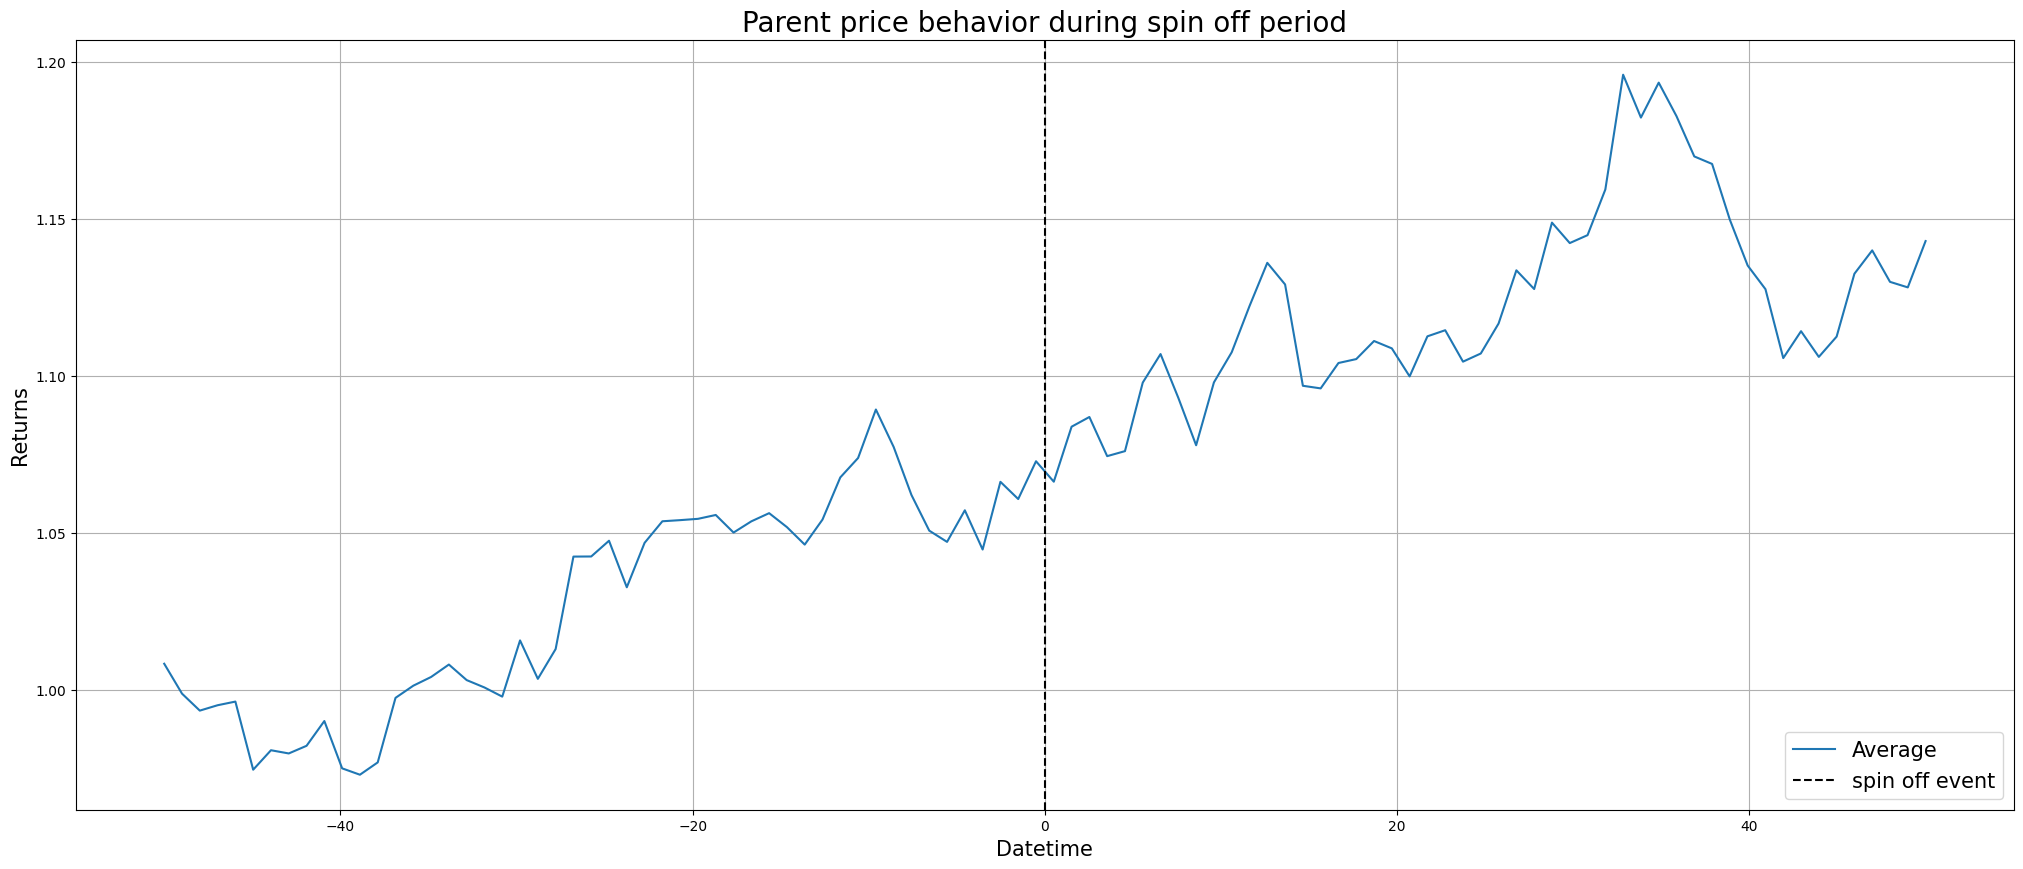

In [6]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(25, 10))

ax.plot(
    np.linspace(-DAYS_BEFORE, DAYS_AFTER, num=DAYS_BEFORE + DAYS_AFTER),
    np.mean(behaviours, axis=0),
    label="Average",
)
ax.axvline(x=0, color="black", label="spin off event", linestyle="--")
ax.grid()
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Returns", fontsize=15)
ax.set_title(f"Parent price behavior during spin off period", fontsize=20)
ax.legend(loc="lower right", fontsize=15)

# Backtest spin off


c:\_sharedFS\Ecole\API Bloomberg\Stock-Performance-Spin-off-Subsidiaries-Parents-ETF\src\backtest\metrics.py:378: RuntimeWarning: invalid value encountered in scalar divide
  return (N * (portfolio_returns - benchmark_returns).mean()) / (



-------  Returns statistical information  --------
Expected return annualized: 7.01 % vs 7.01 % (benchmark)
CAGR: 5.20 % vs 5.20 % (benchmark)
Expected volatility annualized: 19.17 % vs 19.17 % (benchmark)
Specific volatility (diversifiable) annualized: 0.00 %
Systematic volatility annualized: 19.17 %
Skewness: -0.15 vs -0.15 (benchmark), <0 = left tail, >0 = right tail
Kurtosis: 10.67 vs -0.15 (benchmark) , >3 = fat tails, <3 = thin tails
95%-VaR: -1.84 % vs -1.84 % (benchmark) -> the lower the better
95%-CVaR: -2.91 % vs -2.91 % (benchmark) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -56.78 % vs -56.78 % (benchmark)
Kelly criterion: 3.65 % vs 3.65 % (benchmark)
Benchmark sensitivity (beta): 1.00 vs 1 (benchmark)
Determination coefficient R²: 1.00
Tracking error annualized: 0.00 %

---------------  Strategy ratios  ----------------
No risk free rate considered for the following ratios.

Sharpe ratio annualized: 0.37 vs 0.37 (benchmark)
So

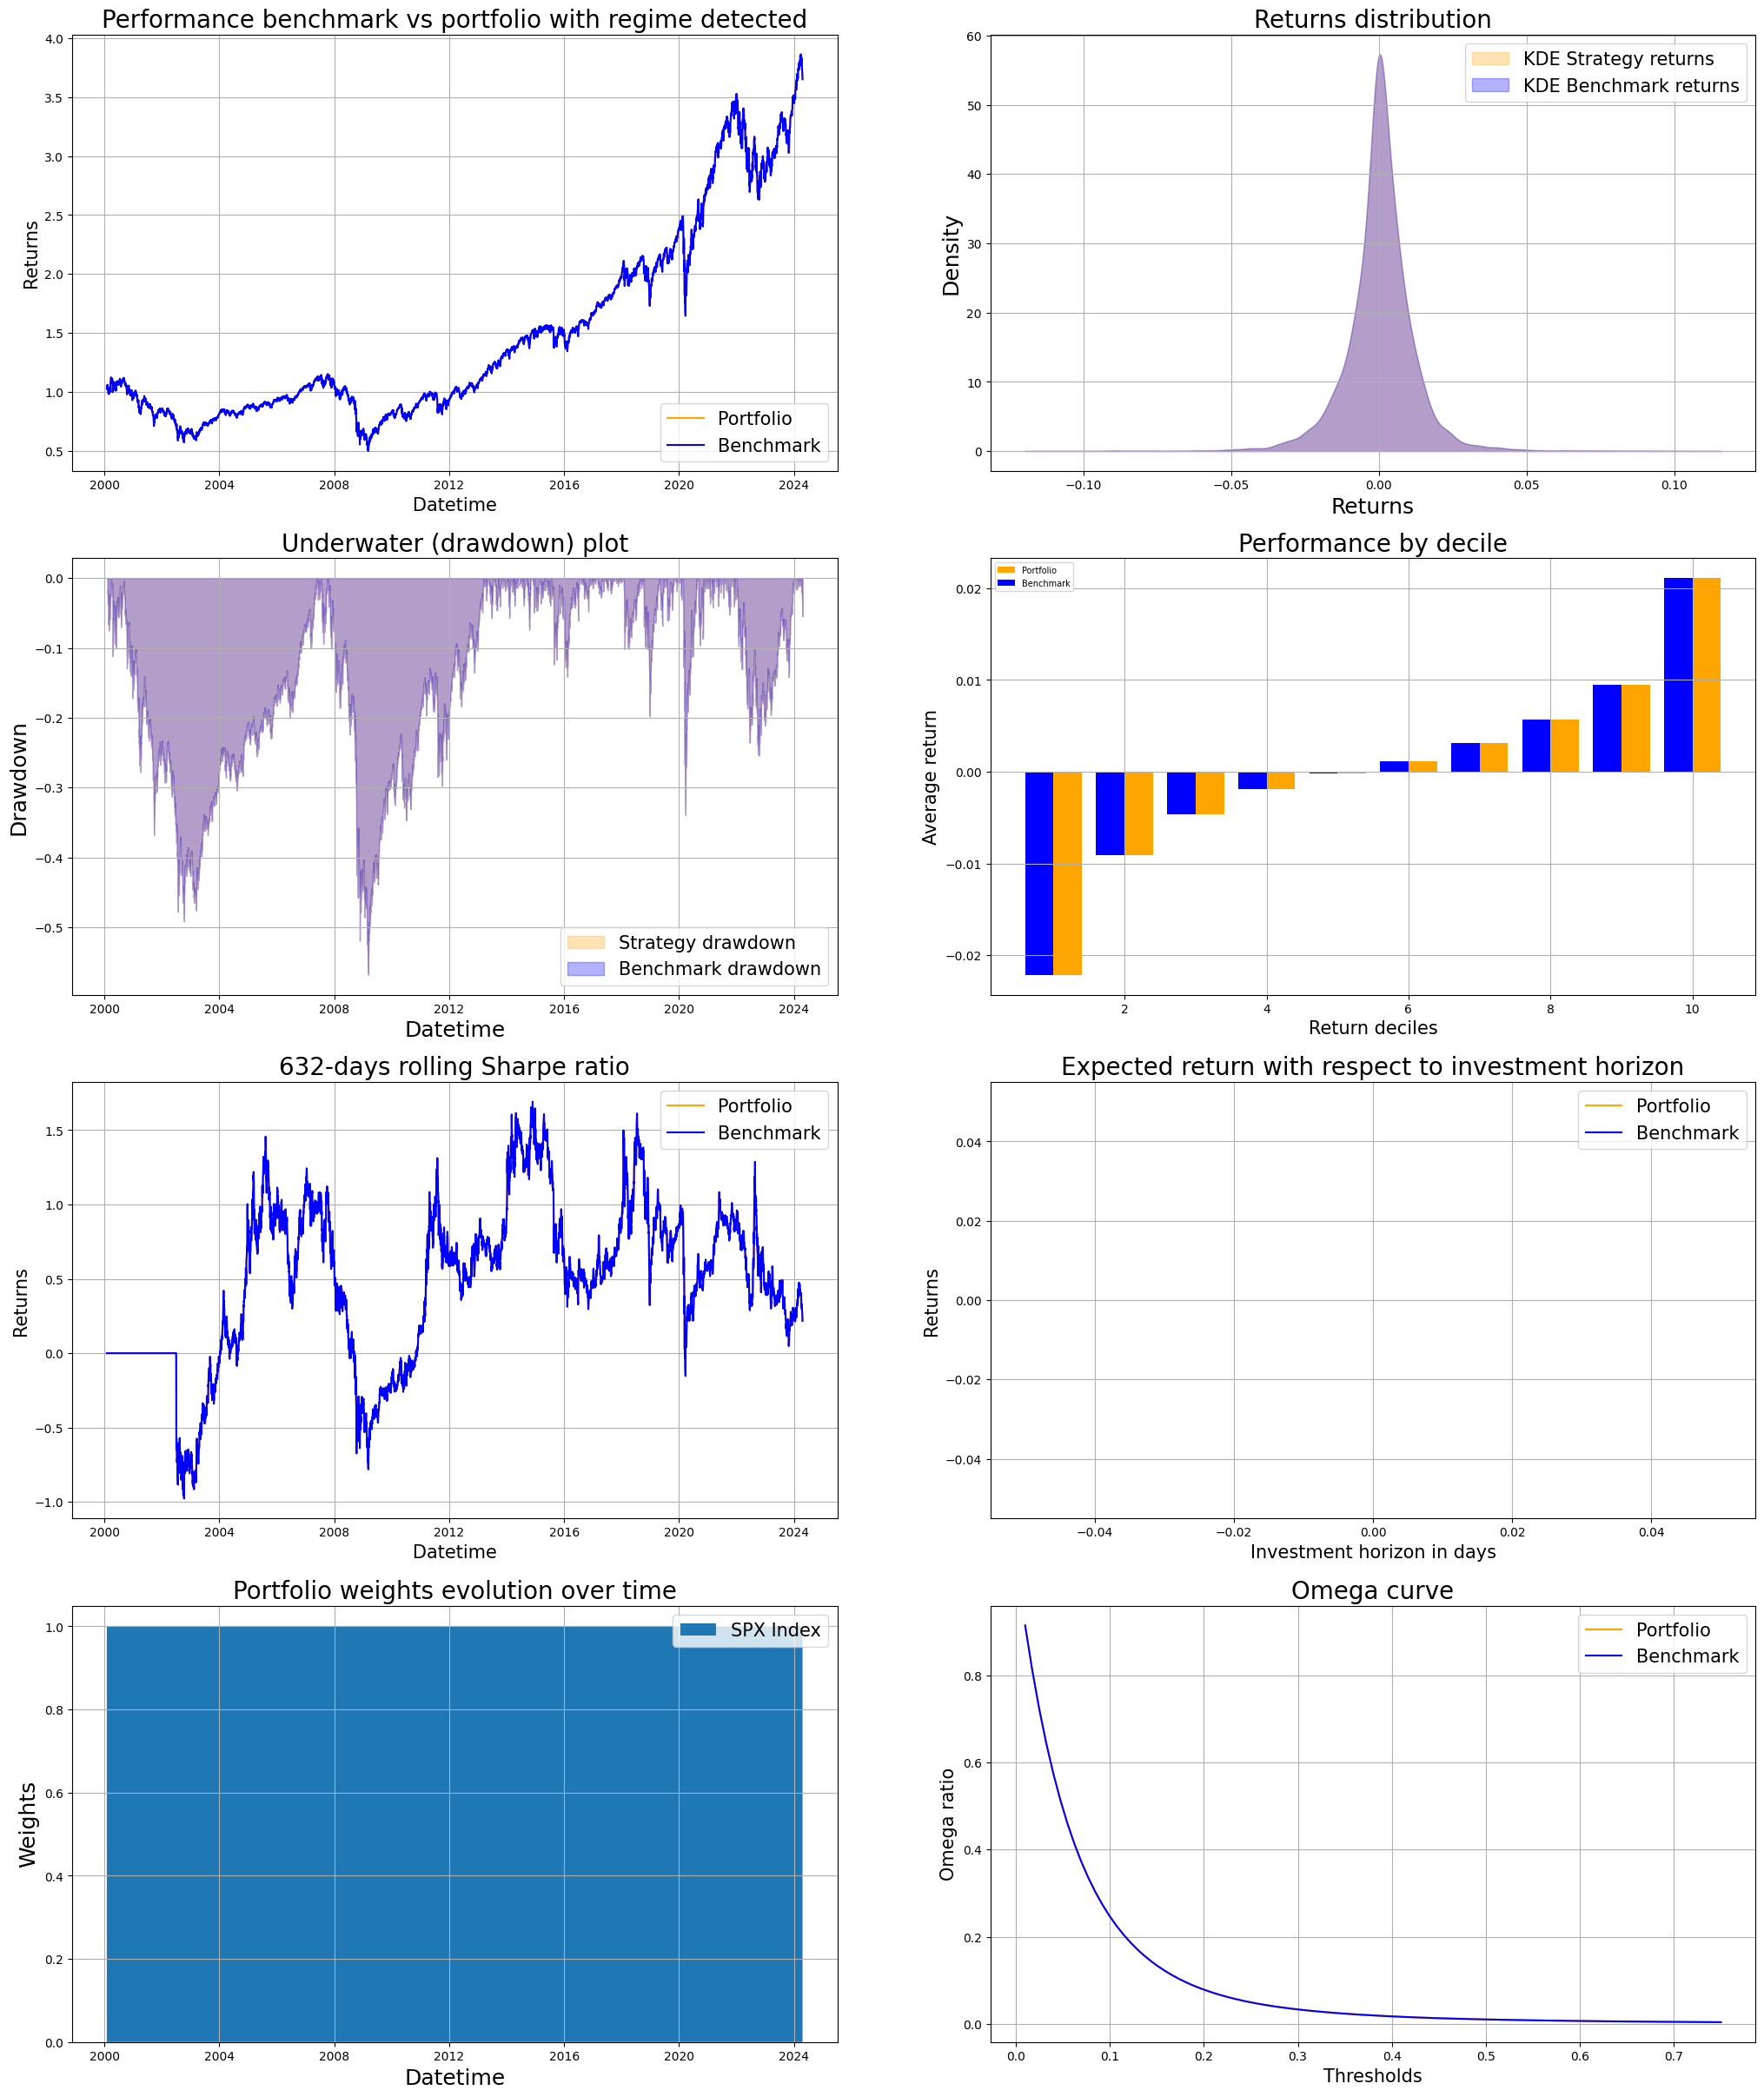

In [7]:
bk_test = Backtester(
    universe_returns=univ.get_universe_returns(),
    benchmark_returns=bench.get_benchmark_returns("SPX Index"),
)

ptf_and_bench, ptf_weights_df, ptf_metrics_df = bk_test.run_backtest(
    AllocationMethodsEnum.EQUALLY_WEIGHTED,
    spin_off_events_announcement=spin_off_announcement,
    backtest_type="parents",
    holding_period_in_months=15,
    transaction_cost=0.001,  # 10 BP
)